# hw05

## 1.请描述MACD的使用方法

第一种方法：当短期均线下穿长期均线（死叉）时卖出，当短期均线上穿长期均线（金叉）时买入
第二种方法：看背离，当本次上涨创新高，而红柱子比上次短时，说明发生背离，可以卖出

## 2.请找出任意一个MACD的顶背离与底背离，并截图
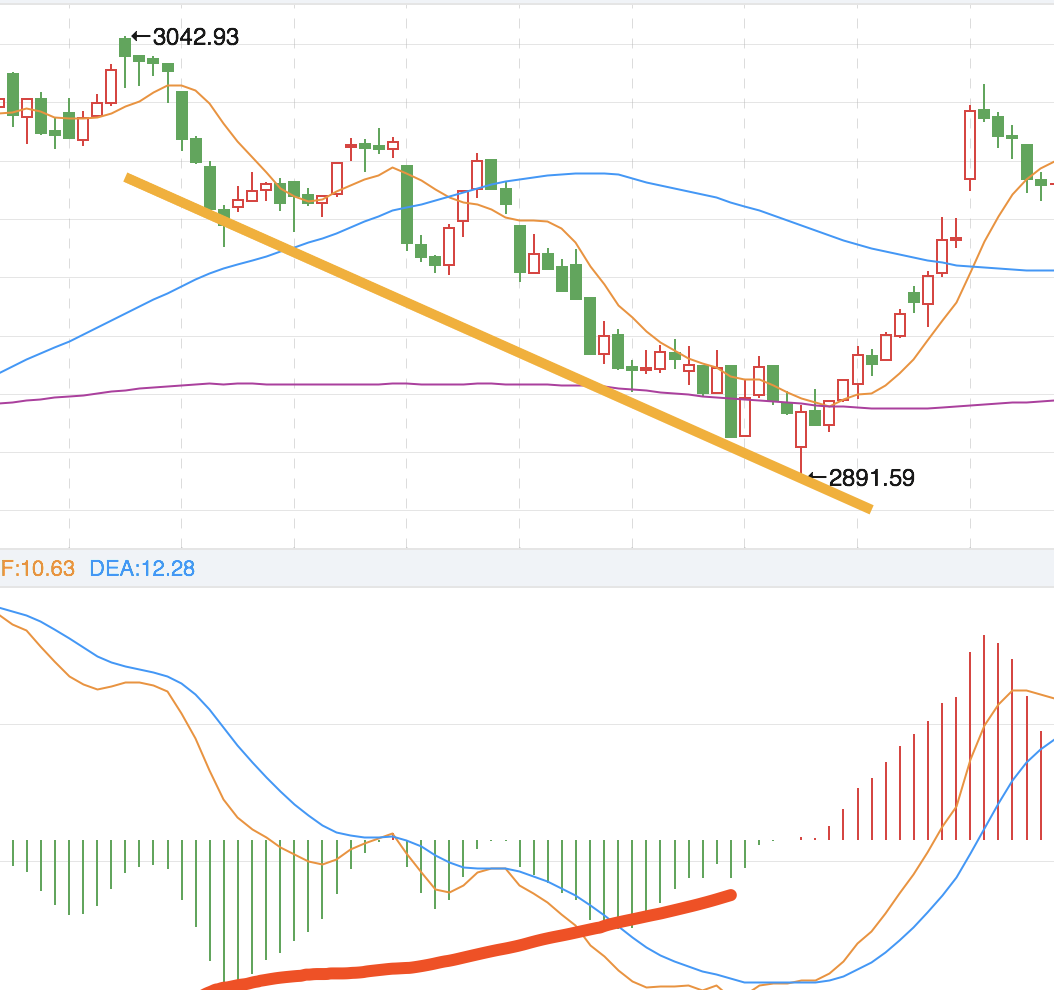